In [31]:
import os
import pandas as pd
import warnings

from datetime import datetime, timedelta
from dython.nominal import associations
from sklearn.model_selection import train_test_split

import shap

# Surpress matrics warnings
import warnings
import sys
from sklearn.exceptions import UndefinedMetricWarning
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)
class DevNull:
    def write(self, msg): pass
    def flush(self): pass
sys.stderr = DevNull()

# Pandas formating
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Modeling

This notebook contains the following major sections:

1. Define a utility function for parsing weather data and load the weather dataset  
2. Load and join preprocessed data: `checkouts`, `books`, `customers`, `libraries`, and calculated distances  
3. Extract the target label  
4. Subset the dataset — keep only valid samples and downsample the majority class  
5. Select numerical and categorical features for modeling  
6. Perform association analysis  
7. Encode categorical features  
8. Perform train-test split  
9. Train a Logistic Regression model  
10. Train a Logistic Regression model with polynomial features  
11. Train a Random Forest model  
12. Train an XGBoost model  
13. Evaluate all models on the test dataset
14. Draw final conclusions  



### Main Features

- **From the customers table**: `age`, `gender`, `education`, `occupation`  
- **From the books table**: `book_age`, `number_of_pages`, `price`  
- **Customer and library**: Driving distance between customer address and library address  
- **Weather data**:  
  - Average temperature  
  - Ratio of rainy days  
  - Average wind speed  
  These metrics are calculated for the 28-day period following the checkout date.  
  In this case, historical weather reports were used. However, since these are summary metrics, similar values could be estimated reliably in a production setting using weather forecasts.



### Target Variable

The target variable is derived from the difference between the `checkout_date` and `return_date`.  
- If the book is returned **more than 28 days** after the checkout date → `target = 1` (returned late)  
- Otherwise → `target = 0` (returned on time)



### Addressing Class Imbalance

Class imbalance is handled in two ways:

- **Downsampling** the majority class
- **Applying class weights** to increase the influence of minority class samples during training



### Data Split

- The data is split into **training and test sets** using a 75/25 ratio  
- Model training and evaluation are done using **Stratified K-Fold Cross-Validation**  
- The primary model selection metric is **F1 score**, with **precision**, **accuracy**, and **recall** also reported  

Hyperparameter tuning is performed via **grid search** using cross-validation **only on the training set**.  
The test set is reserved strictly for final evaluation.



### Model Explainability

**SHAP (SHapley Additive exPlanations)** values are used to assess:
- Overall feature importance  
- How each feature influences individual predictions  

This helps interpret model behavior and understand the driving factors behind predictions.


## Define weather parsing utility function and load weather data

Define function that calculates wind info, rain info, temperature info for the period of 28 days after book checkout date.

In [32]:
weather_data = pd.read_csv('data_preprocessed/weather_data.csv')
weather_data['time'] = pd.to_datetime(weather_data['time'], errors='coerce')

def get_interval_weather_info(row: pd.Series):
    """
    This function calculates average temperature,
    wind and ratio of rainy days in the period of
    28 days after checkout date.

    Args:
        row (pd.Series): Single dataframe row.

    Returns:
        Wind info, rain info, temperature info.
    """
    
    try:
        start_date = row['date_checkout_fix']
        start_and_28 = start_date + timedelta(days=28)
        weather_data_slice = weather_data[
            (weather_data['time']<start_and_28) 
            & (weather_data['time']>start_date)
        ]
        avg_temp = weather_data_slice['tavg'].mean()
        avg_wind = weather_data_slice['wspd'].mean()
        ratio_rainy = (weather_data_slice['prcp'] > 0).sum() / weather_data_slice.shape[0]
        
        return pd.Series({
            'avg_temp': avg_temp,
            'avg_wind': avg_wind,
            'ratio_rainy': ratio_rainy 
        })
    except:
        return pd.Series({
            'avg_temp': None,
            'avg_wind': None,
            'ratio_rainy': None 
        })

## Load and merge the tables

In [33]:
# Get checkouts 
checkouts_df = pd.read_csv('data_preprocessed/checkouts_processed.csv')
# Format dates
checkouts_df['date_checkout_fix'] = pd.to_datetime(checkouts_df['date_checkout_fix'], errors='coerce')
checkouts_df['date_returned_fix'] = pd.to_datetime(checkouts_df['date_returned_fix'], errors='coerce')
# Add weather info
checkouts_df[['avg_temp', 'avg_wind', 'ratio_rainy']] = checkouts_df.apply(get_interval_weather_info, axis=1)
checkouts_df = checkouts_df.drop(columns=['date_checkout_fix','date_returned_fix', 'valid', 'invalid', 'date_checkout', 'date_returned', 'days_diff'])

# Libraries - info not used directly
lib_df = pd.read_csv('data_preprocessed/libraries_with_geo.csv', index_col='id')

# Customers
customers_df = pd.read_csv('data_preprocessed/customers_processed.csv', index_col='id')
customers_df = customers_df[['gender', 'education', 'occupation', 'age', 'age_imputed',	'impute_occupation', 'impute_education']]
customers_df.head()

# Books
books_df = pd.read_csv('data_preprocessed/books_processed.csv', index_col='id')
books_df = books_df[['price', 'pages', 'book_age', 'price_imputed', 'book_age_imputed']]
books_df.head()

# Customer bookstore df
distance_df = pd.read_csv('new_data/lib_cust_dist.csv', index_col='Unnamed: 0')

In [34]:
# Join customer data, book data and library data to checouts dataframe
checkouts_df = checkouts_df.join(
    customers_df.add_prefix('cust_'), 
    on="patron_id", 
    how="left"
)

checkouts_df = checkouts_df.join(
    books_df.add_prefix('bk_'), 
    on="id", 
    how="left"
)

checkouts_df = pd.merge(
    checkouts_df,distance_df, 
    left_on=['patron_id', 'library_id'], 
    right_on=['customer_id', 'library_id'],
)

checkouts_df['cust_gender'] = checkouts_df['cust_gender'].str.lower()
checkouts_df['cust_gender'] = checkouts_df['cust_gender'].str.strip()

## Extract the label

All books that are returned more than 28 days after checkouts are considered late returns.

Experimental: All books with missing date are also considered as late returns.

In [35]:
checkouts_df['returned_late'] = checkouts_df['fixed_days_diff'] > 28
checkouts_df.loc[checkouts_df['sample_type']=='no_return', 'returned_late'] = True

# Calculate number of value imputations for each sample
checkouts_df['num_imputations'] = (
    checkouts_df['cust_age_imputed'].astype(int) + checkouts_df['cust_impute_occupation'].astype(int)
    + checkouts_df['cust_impute_education'].astype(int) + checkouts_df['bk_price_imputed'].astype(int)
    +  checkouts_df['bk_book_age_imputed'].astype(int)
)

target_col = 'returned_late'

In [36]:
checkouts_df.head()

,id,patron_id,library_id,sample_type,fixed_days_diff,avg_temp,avg_wind,ratio_rainy,cust_gender,cust_education,cust_occupation,cust_age,cust_age_imputed,cust_impute_occupation,cust_impute_education,bk_price,bk_pages,bk_book_age,bk_price_imputed,bk_book_age_imputed,customer_id,distance,duration,returned_late,num_imputations
0,-xFj0vTLbRIC,b071c9c68228a2b1d00e6f53677e16da,225-222@5xc-jtz-hkf,checkout_fixed,289.0,6.266667,9.214815,0.481481,female,high school,tech,44.876404,False,False,True,144.50,513,12.0,False,False,b071c9c68228a2b1d00e6f53677e16da,0.891,0.040278,True,1
1,HUX-y4oXl04C,8d3f63e1deed89d7ba1bf6a4eb101373,223-222@5xc-jxr-tgk,valid,14.0,17.600000,9.651852,0.296296,female,graduate degree,tech,55.337079,False,False,False,416.99,752,13.0,False,False,8d3f63e1deed89d7ba1bf6a4eb101373,2.745,0.091389,False,0
2,TQpFnkku2poC,4ae202f8de762591734705e0079d76df,228-222@5xc-jtz-hwk,valid,62.0,7.196296,17.011111,0.518519,male,graduate degree,education & health,56.592697,False,False,False,217.00,790,15.0,False,False,4ae202f8de762591734705e0079d76df,2.721,0.108056,True,0
3,OQ6sDwAAQBAJ,f9372de3c8ea501601aa3fb59ec0f524,23v-222@5xc-jv7-v4v,valid,100.0,8.151852,12.133333,0.592593,male,graduate degree,sales,44.876404,True,False,False,190.50,597,0.0,False,False,f9372de3c8ea501601aa3fb59ec0f524,4.835,0.113333,True,1
4,7T9-BAAAQBAJ,2cf3cc3b9e9f6c608767da8d350f77c9,225-222@5xc-jtz-hkf,return_fixed_up,23.0,6.325926,14.407407,0.481481,female,others,business & finance,44.876404,True,False,False,406.99,774,4.0,False,False,2cf3cc3b9e9f6c608767da8d350f77c9,8.277,0.267500,False,1


## Subset the data

Including samples with imputed or corrected checkout/return dates was found to degrade classifier performance.
As a result, only samples with valid, original date values are used for model training.

Majority data is subsamplet in order to mitigate influence of class imbalance.

In [37]:
# Varuous sample types can be included at this stage
sub_checkout_df = checkouts_df[checkouts_df['sample_type'].isin(['valid'])]

# Subdsmple majority(only use records where data was not imputed)
df_0 = sub_checkout_df[(sub_checkout_df[target_col] == 0) & (sub_checkout_df['num_imputations']==0)].sample(n=400, random_state=42)  # downsample to 400
df_1 = sub_checkout_df[sub_checkout_df[target_col] == 1]  # keep all class 1

# Combine and shuffle
sub_checkout_df = pd.concat([df_0, df_1]).sample(frac=1, random_state=42).reset_index(drop=True)


In [38]:
# Check distribution across libraries in the subsampled data
# Conclusion - It seems that samples and labels are evenly distributed across libraries
lib_vs_return = sub_checkout_df[['library_id', target_col]].value_counts().unstack(fill_value=0)
lib_vs_return

returned_late,False,True
library_id,,
222-222@5xc-jv5-nt9,20,7
222-222@5xc-jvf-skf,16,5
222-222@5xc-jxp-rp9,15,10
222-222@5xc-kkw-bzf,26,6
223-222@5xc-jxr-tgk,26,9
224-222@5xc-jw2-t9z,24,3
225-222@5xc-jtz-hkf,26,10
226-222@5xc-jxj-7yv,20,6
226-222@5xc-kc4-fpv,24,4


## Select features and start analysus

In [39]:
numerical_features = ['cust_age', 'bk_price', 'bk_pages', 'bk_book_age', 'distance',  'avg_temp', 'avg_wind', 'ratio_rainy']
categ_features = ['cust_gender' , 'cust_education', 'cust_occupation']
all_features = numerical_features + categ_features

In [40]:
features_and_label = all_features + [target_col]
features_df = sub_checkout_df[all_features]
target = sub_checkout_df[target_col]

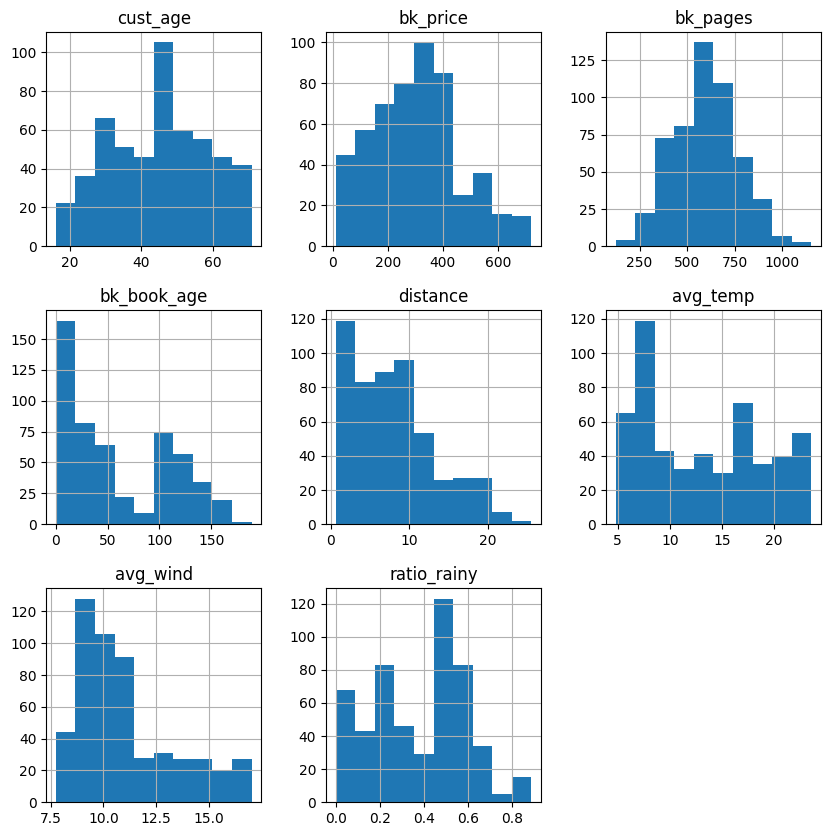

In [41]:
# Check distribution of numerical features
# Conclusion - no extreme skewness spotted
_ = features_df.hist(figsize=(10,10))

## Associations

### Feature–Feature Associations:
- Strong correlations are observed among the weather-related features  
- Book price and number of pages are also strongly correlated  
- No other strong associations are found between the remaining features

### Feature–Target Associations:
- The driving distance between the customer and the library shows a moderate-strong association with the target variable. (association is measured with Crammer v between numerical and categorical)
- Book price and number of pages exhibit moderate association with the target (crammer V)

CrammerV value interpretation (https://www.ibm.com/docs/en/cognos-analytics/11.1.x?topic=terms-cramrs-v)

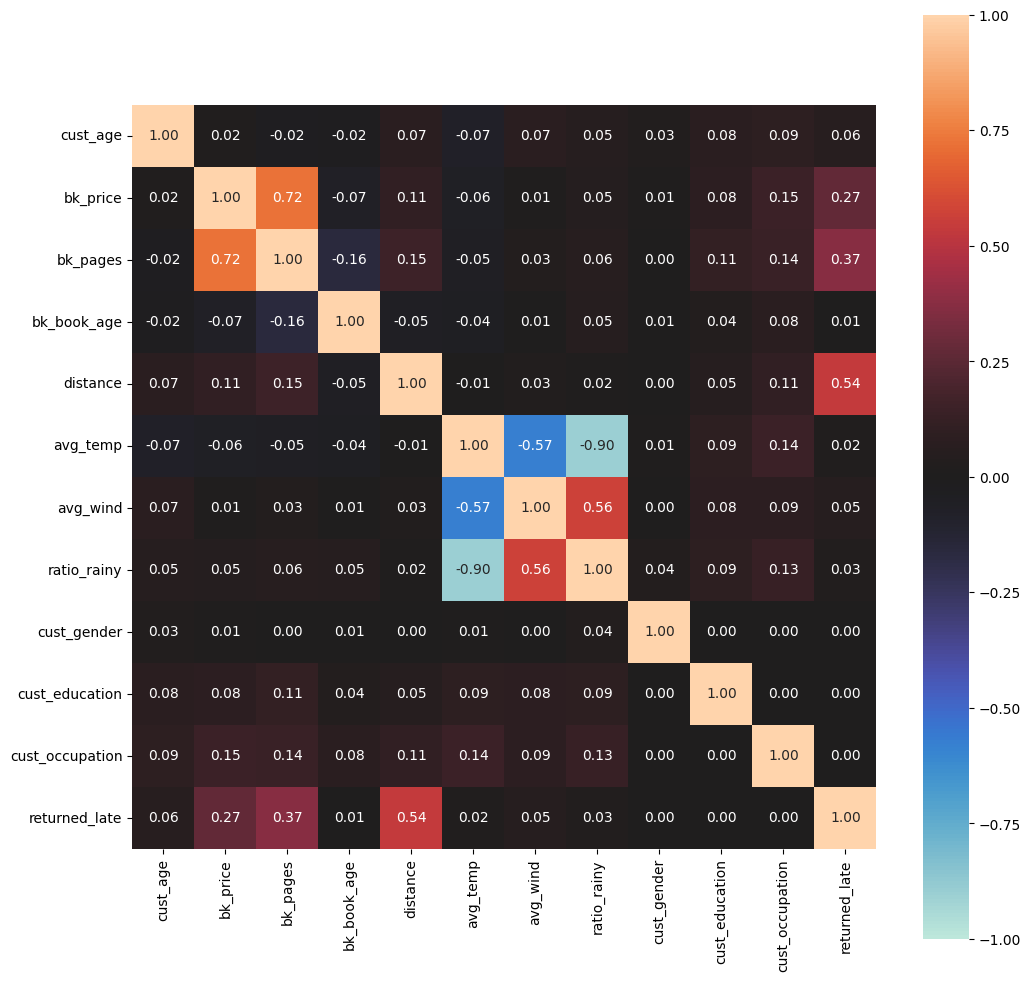

In [42]:
assoc_df = associations(
    sub_checkout_df[features_and_label],
    nominal_columns=categ_features + [target_col],
    numerical_columns=numerical_features,
    figsize=(12,12)
)

## Encode categorical features

Categorical features are one-hot encoded by using pandas get dummies function.

In [43]:
dummy_info = {}

for col in categ_features:
    dummies = pd.get_dummies(features_df[col], prefix=col, drop_first=True, dtype=int)
    dummy_info[col] = dummies.columns  # save column names for reverse mapping
    features_df = features_df.drop(columns=col).join(dummies)

In [44]:
features_df.head(2)

,cust_age,bk_price,bk_pages,bk_book_age,distance,avg_temp,avg_wind,ratio_rainy,cust_gender_male,cust_education_graduate degree,cust_education_high school,cust_education_others,cust_occupation_blue collar,cust_occupation_business & finance,cust_occupation_education & health,cust_occupation_others,cust_occupation_sales,cust_occupation_tech
0,68.926966,287.5,369,20.0,7.669,13.248148,8.285185,0.481481,0,0,1,0,0,1,0,0,0,0
1,30.710674,31.0,442,39.0,5.377,5.000000,10.477778,0.481481,1,0,0,0,0,0,0,0,0,0


## Data split

Stratified split was used in order to keep the same label balance in both datasets.

In [45]:
X_train, X_test, y_train, y_test = train_test_split(
    features_df, target, test_size=0.25, 
    random_state=42, stratify=target
)

## K-Fold Cross-Validation & Grid Search

For each model, optimal hyperparameters are selected using grid search.  

Model performance is evaluated using stratified K-Fold cross-validation with **k = 3**.  
The stratified version is chosen to ensure that each fold maintains the same class distribution as the full dataset.  
This is essential due to class imbalance, which could otherwise result in folds containing only a single class.

Best model is selected by using f1-score. Precission, recall and accuracy are also calculated for all the models.

## Regular logistic regression

Regular Logistic Regression with support for various regularization options and class weighting to handle imbalance.

Shap values are ommited due to high number of polynomial features.

In [46]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from xgboost import XGBClassifier

In [47]:
param_grid = {
    'penalty': ['l2', 'l1'],
    'C': [0.01, 0.1, 1, 10, 100, 300],
    'class_weight': ['balanced', None]
}

# Define scoring
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'f1': make_scorer(f1_score)
}

skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

log_grid = GridSearchCV(
    estimator=LogisticRegression(solver='liblinear'),
    param_grid=param_grid,
    scoring=scoring,
    refit='f1',
    cv=skf,
    return_train_score=True,
    n_jobs=-1
)

# Fit the grid
log_grid.fit(X_train, y_train)

cv_df = pd.DataFrame(log_grid.cv_results_).sort_values('mean_test_f1', ascending=False)
display(cv_df[['params', 'mean_test_accuracy', 'mean_test_precision', 'mean_test_recall', 'mean_test_f1']].head(10))

print('Best parameters :')
print(log_grid.best_params_)


,params,mean_test_accuracy,mean_test_precision,mean_test_recall,mean_test_f1
12,"{'C': 10, 'class_weight': 'balanced', 'penalty...",0.795455,0.566296,0.761995,0.646971
9,"{'C': 1, 'class_weight': 'balanced', 'penalty'...",0.792929,0.561602,0.761995,0.643721
13,"{'C': 10, 'class_weight': 'balanced', 'penalty...",0.787879,0.551454,0.772412,0.641187
14,"{'C': 10, 'class_weight': None, 'penalty': 'l2'}",0.838384,0.711143,0.587753,0.639612
21,"{'C': 300, 'class_weight': 'balanced', 'penalt...",0.787879,0.555571,0.761995,0.639191
20,"{'C': 300, 'class_weight': 'balanced', 'penalt...",0.787879,0.555571,0.761995,0.639191
17,"{'C': 100, 'class_weight': 'balanced', 'penalt...",0.787879,0.555571,0.761995,0.639191
16,"{'C': 100, 'class_weight': 'balanced', 'penalt...",0.785354,0.549815,0.761995,0.635923
18,"{'C': 100, 'class_weight': None, 'penalty': 'l2'}",0.833333,0.693297,0.577336,0.628322
22,"{'C': 300, 'class_weight': None, 'penalty': 'l2'}",0.828283,0.677564,0.577336,0.621364


Best parameters :
{'C': 10, 'class_weight': 'balanced', 'penalty': 'l2'}


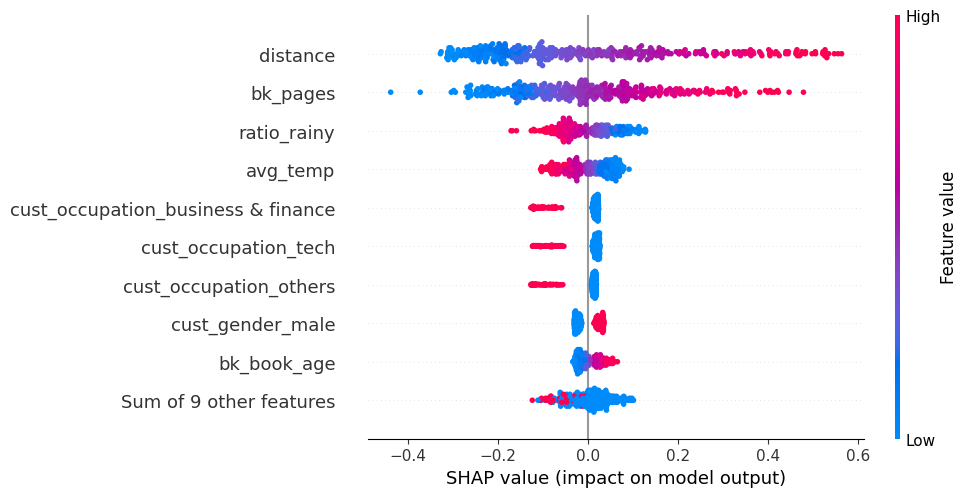

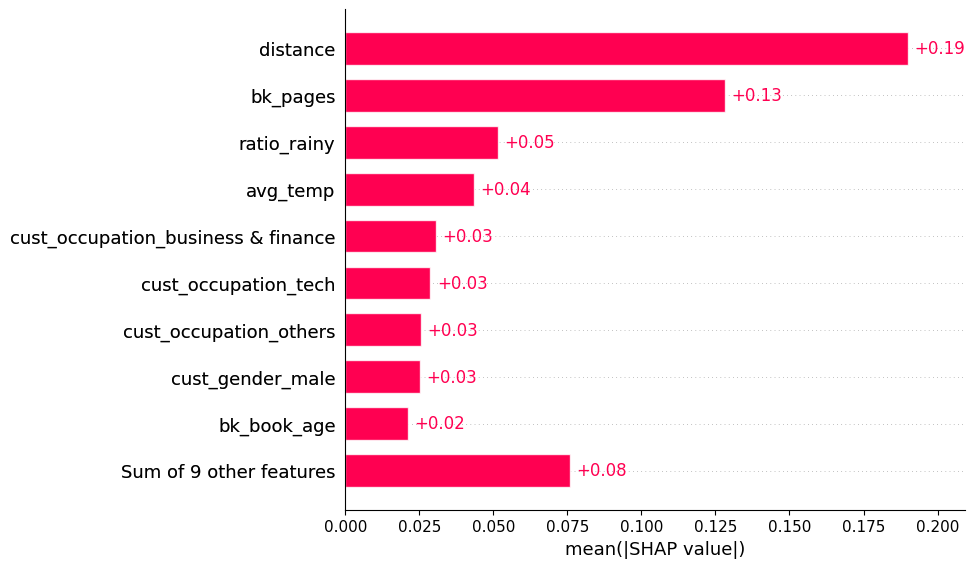

In [48]:
# Shap analysis
explainer = shap.Explainer(log_grid.best_estimator_.predict_proba, X_train, link=shap.links.identity)
shap_values = explainer(X_train)
shap.plots.beeswarm(shap_values[:,:,1])
shap.plots.bar(shap_values[:,:,1])

## Logistic regression with polynomial features

Regular Logistic Regression with support for various regularization options and class weighting to handle imbalance.  
Polynomial and interaction features are included to enhance the model’s ability to capture non-linear relationships and improve predictive performance.


In [49]:
# Define pipeline
pipeline = Pipeline([
    ('poly', PolynomialFeatures(include_bias=False)),
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(solver='liblinear'))
])

# Parameter grid including polynomial degree
param_grid = {
    'poly__degree': [1, 2],  # try linear and polynomial terms
    'poly__interaction_only': [False, True],  # test pure interactions
    'clf__penalty': ['l2', 'l1'],
    'clf__C': [0.01, 0.1, 1, 10, 100],
    'clf__class_weight': ['balanced', None]
}

# Define scoring
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'f1': make_scorer(f1_score)
}

skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

log_grid_poly = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring=scoring,
    refit='f1',
    cv=skf,
    return_train_score=True,
    n_jobs=-1
)

# Fit the grid
log_grid_poly.fit(X_train, y_train)

cv_df = pd.DataFrame(log_grid_poly.cv_results_).sort_values('mean_test_f1', ascending=False)
display(cv_df[['params', 'mean_test_accuracy', 'mean_test_precision', 'mean_test_recall', 'mean_test_f1']].head(20))

print('Best parameters :')
print(log_grid_poly.best_params_)

,params,mean_test_accuracy,mean_test_precision,mean_test_recall,mean_test_f1
11,"{'clf__C': 0.01, 'clf__class_weight': None, 'c...",0.820707,0.616039,0.731061,0.665217
10,"{'clf__C': 0.01, 'clf__class_weight': None, 'c...",0.820707,0.612547,0.731061,0.664469
37,"{'clf__C': 1, 'clf__class_weight': 'balanced',...",0.803030,0.574009,0.793245,0.664258
36,"{'clf__C': 1, 'clf__class_weight': 'balanced',...",0.803030,0.574009,0.793245,0.664258
23,"{'clf__C': 0.1, 'clf__class_weight': 'balanced...",0.800505,0.572619,0.792929,0.661673
22,"{'clf__C': 0.1, 'clf__class_weight': 'balanced...",0.800505,0.572619,0.792929,0.661673
21,"{'clf__C': 0.1, 'clf__class_weight': 'balanced...",0.790404,0.549193,0.833965,0.659989
20,"{'clf__C': 0.1, 'clf__class_weight': 'balanced...",0.790404,0.549193,0.833965,0.659989
17,"{'clf__C': 0.1, 'clf__class_weight': 'balanced...",0.795455,0.561746,0.793245,0.655908
16,"{'clf__C': 0.1, 'clf__class_weight': 'balanced...",0.795455,0.561746,0.793245,0.655908


Best parameters :
{'clf__C': 0.01, 'clf__class_weight': None, 'clf__penalty': 'l2', 'poly__degree': 2, 'poly__interaction_only': True}


## Random Forest Classifier

The Random Forest classifier is well-suited for capturing complex, non-linear patterns in the data.  
Its ensemble structure helps mitigate the overfitting tendencies commonly seen in individual decision trees.

The model is evaluated with a focus on:
- Preventing overfitting at the tree level (e.g. through depth control and leaf size)
- Tuning the number of trees in the ensemble
- Adjusting class weights to address class imbalance

Feature importance is evaluated using two approaches:
- **SHAP values**
- The **native feature importance scores** provided by the Random Forest model based on impurity reduction


In [50]:
param_grid = {
    'n_estimators': [100, 200, 500, 800],
    'max_depth': [3, 6, 10],
    'min_samples_split': [2,5],
    'min_samples_leaf': [2, 3, 5],
    'class_weight': [None, 'balanced']
}

# Define scoring
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'f1': make_scorer(f1_score)
}

skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

rf_grid = GridSearchCV(
    estimator=RandomForestClassifier(n_jobs=-1),
    param_grid=param_grid,
    scoring=scoring,
    refit='f1',
    cv=skf,
    return_train_score=True,
    n_jobs=-1
)

# Fit the grid
rf_grid.fit(X_train, y_train)

cv_df = pd.DataFrame(rf_grid.cv_results_).sort_values('mean_test_f1', ascending=False)
display(cv_df[['params', 'mean_test_accuracy', 'mean_test_precision', 'mean_test_recall', 'mean_test_f1']].head(20))

print('Best parameters :')
print(rf_grid.best_params_)

,params,mean_test_accuracy,mean_test_precision,mean_test_recall,mean_test_f1
90,"{'class_weight': 'balanced', 'max_depth': 3, '...",0.909091,0.851879,0.772096,0.805083
83,"{'class_weight': 'balanced', 'max_depth': 3, '...",0.909091,0.857284,0.761995,0.803403
81,"{'class_weight': 'balanced', 'max_depth': 3, '...",0.909091,0.867160,0.751578,0.800829
137,"{'class_weight': 'balanced', 'max_depth': 10, ...",0.909091,0.875518,0.741477,0.799281
104,"{'class_weight': 'balanced', 'max_depth': 6, '...",0.909091,0.875518,0.741477,0.799281
79,"{'class_weight': 'balanced', 'max_depth': 3, '...",0.909091,0.875518,0.741477,0.799281
107,"{'class_weight': 'balanced', 'max_depth': 6, '...",0.909091,0.882361,0.731376,0.797387
94,"{'class_weight': 'balanced', 'max_depth': 3, '...",0.906566,0.867497,0.741477,0.795210
86,"{'class_weight': 'balanced', 'max_depth': 3, '...",0.906566,0.867497,0.741477,0.795210
87,"{'class_weight': 'balanced', 'max_depth': 3, '...",0.906566,0.867497,0.741477,0.795210


Best parameters :
{'class_weight': 'balanced', 'max_depth': 3, 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 500}


In [51]:
# Balpark estimate of feature importance
pd.Series(
    rf_grid.best_estimator_.feature_importances_,
    index=rf_grid.best_estimator_.feature_names_in_
).sort_values(ascending=False)

distance                              0.377793
bk_pages                              0.302468
bk_price                              0.118615
cust_age                              0.064105
avg_wind                              0.030301
avg_temp                              0.029521
bk_book_age                           0.023976
ratio_rainy                           0.020638
cust_education_graduate degree        0.006700
cust_gender_male                      0.005358
cust_education_others                 0.004816
cust_occupation_sales                 0.003071
cust_occupation_education & health    0.003057
cust_occupation_tech                  0.002968
cust_education_high school            0.001868
cust_occupation_others                0.001771
cust_occupation_business & finance    0.001637
cust_occupation_blue collar           0.001341
dtype: float64

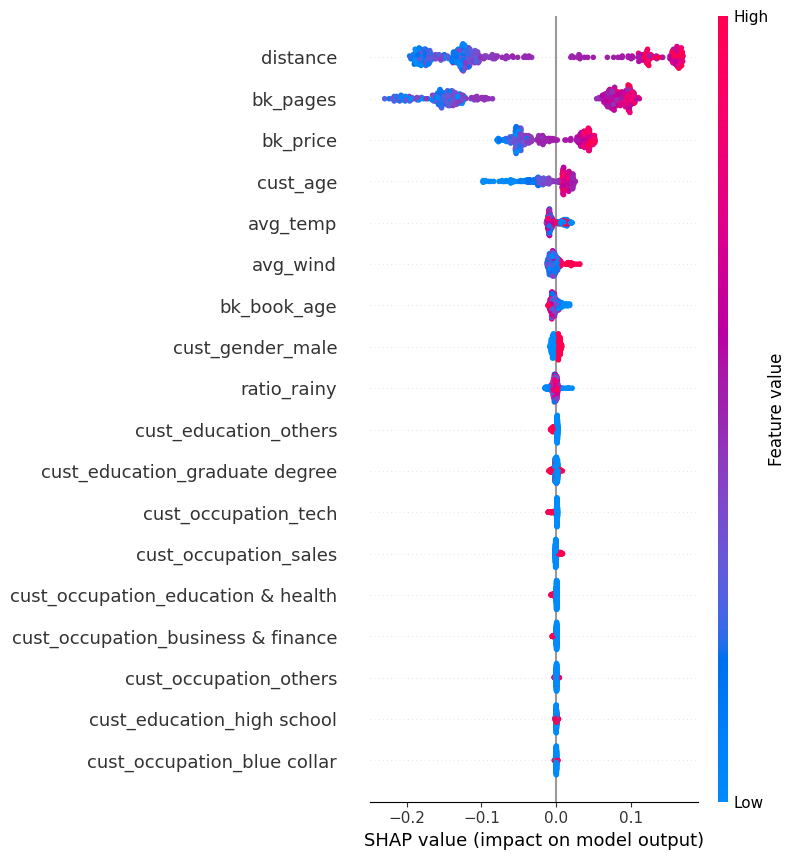

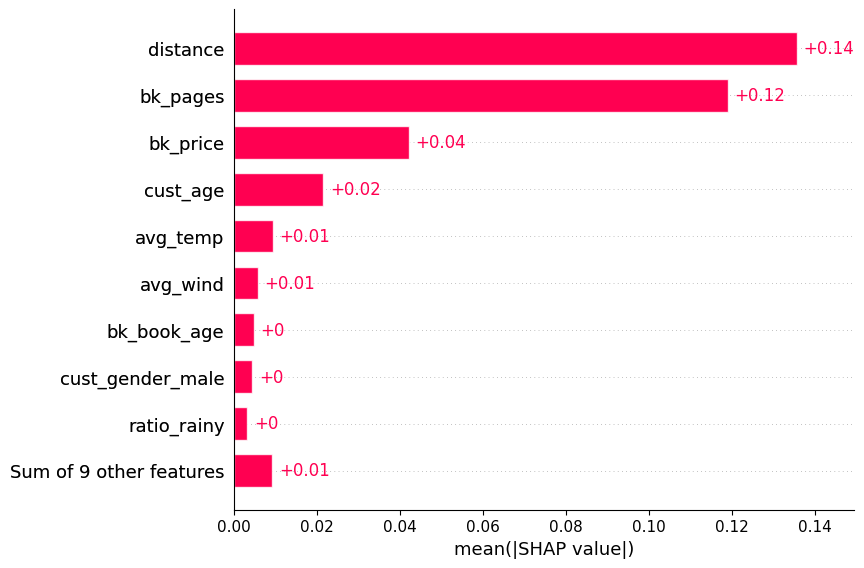

In [52]:
# Shap values
explainer = shap.TreeExplainer(rf_grid.best_estimator_)
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values[:,:,1], X_train)

shap.plots.bar(explainer(X_train)[:,:,1])


## XGBoost Classifier

The XGBoost classifier is a powerful gradient-boosted tree model that is highly effective for structured/tabular data.  
It is capable of capturing complex feature interactions and provides several options for regularization, which helps prevent overfitting.

The model is evaluated with attention to:
- Tree depth and learning rate to balance bias and variance  
- Ensemble size (number of boosting rounds)  
- Learning rate
- Class weighting to address imbalance in the target variable

### Feature Importance

Feature importance is evaluated using two methods:
- **SHAP values**
- **XGBoost’s built-in feature importances**, based on split metrics such as gain, cover, or frequency


In [53]:
scale_pos_weight = sum(y_train == 0) / sum(y_train == 1)

param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [2, 3, 5],
    'learning_rate': [0.001, 0.01, 0.1],
    'subsample': [0.5, 0.8],
    'colsample_bytree': [0.5, 0.8],
    'scale_pos_weight': [scale_pos_weight, None]
}

# Define scoring
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'f1': make_scorer(f1_score)
}

skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

xgb_grid = GridSearchCV(
    estimator=XGBClassifier(n_jobs=-1),
    param_grid=param_grid,
    scoring=scoring,
    refit='f1',
    cv=skf,
    return_train_score=True,
    n_jobs=-1
)

# Fit the grid
xgb_grid.fit(X_train, y_train)

cv_df = pd.DataFrame(xgb_grid.cv_results_).sort_values('mean_test_f1', ascending=False)
display(cv_df[['params', 'mean_test_accuracy', 'mean_test_precision', 'mean_test_recall', 'mean_test_f1']].head(20))

print('Best parameters :')
print(xgb_grid.best_params_)

,params,mean_test_accuracy,mean_test_precision,mean_test_recall,mean_test_f1
124,"{'colsample_bytree': 0.8, 'learning_rate': 0.0...",0.914141,0.891794,0.751578,0.810099
4,"{'colsample_bytree': 0.5, 'learning_rate': 0.0...",0.911616,0.870062,0.761995,0.808206
136,"{'colsample_bytree': 0.8, 'learning_rate': 0.0...",0.914141,0.900112,0.741162,0.806866
20,"{'colsample_bytree': 0.5, 'learning_rate': 0.0...",0.911616,0.876122,0.751894,0.806424
156,"{'colsample_bytree': 0.8, 'learning_rate': 0.0...",0.911616,0.865697,0.761679,0.806105
120,"{'colsample_bytree': 0.8, 'learning_rate': 0.0...",0.911616,0.877301,0.751578,0.805161
140,"{'colsample_bytree': 0.8, 'learning_rate': 0.0...",0.911616,0.877301,0.751578,0.805161
128,"{'colsample_bytree': 0.8, 'learning_rate': 0.0...",0.911616,0.877301,0.751578,0.805161
157,"{'colsample_bytree': 0.8, 'learning_rate': 0.0...",0.911616,0.877301,0.751578,0.805161
172,"{'colsample_bytree': 0.8, 'learning_rate': 0.0...",0.911616,0.877301,0.751578,0.805161


Best parameters :
{'colsample_bytree': 0.8, 'learning_rate': 0.001, 'max_depth': 3, 'n_estimators': 200, 'scale_pos_weight': 3.082474226804124, 'subsample': 0.5}


In [54]:
pd.Series(
    xgb_grid.best_estimator_.feature_importances_,
    index=xgb_grid.best_estimator_.feature_names_in_
).sort_values(ascending=False)

distance                              0.314880
bk_pages                              0.162900
bk_price                              0.051751
cust_age                              0.044191
cust_gender_male                      0.043686
avg_wind                              0.040658
avg_temp                              0.040272
ratio_rainy                           0.040199
cust_education_graduate degree        0.036755
cust_occupation_others                0.035122
bk_book_age                           0.034349
cust_occupation_sales                 0.028988
cust_education_high school            0.028120
cust_education_others                 0.026426
cust_occupation_education & health    0.024815
cust_occupation_tech                  0.023855
cust_occupation_blue collar           0.018686
cust_occupation_business & finance    0.004346
dtype: float32

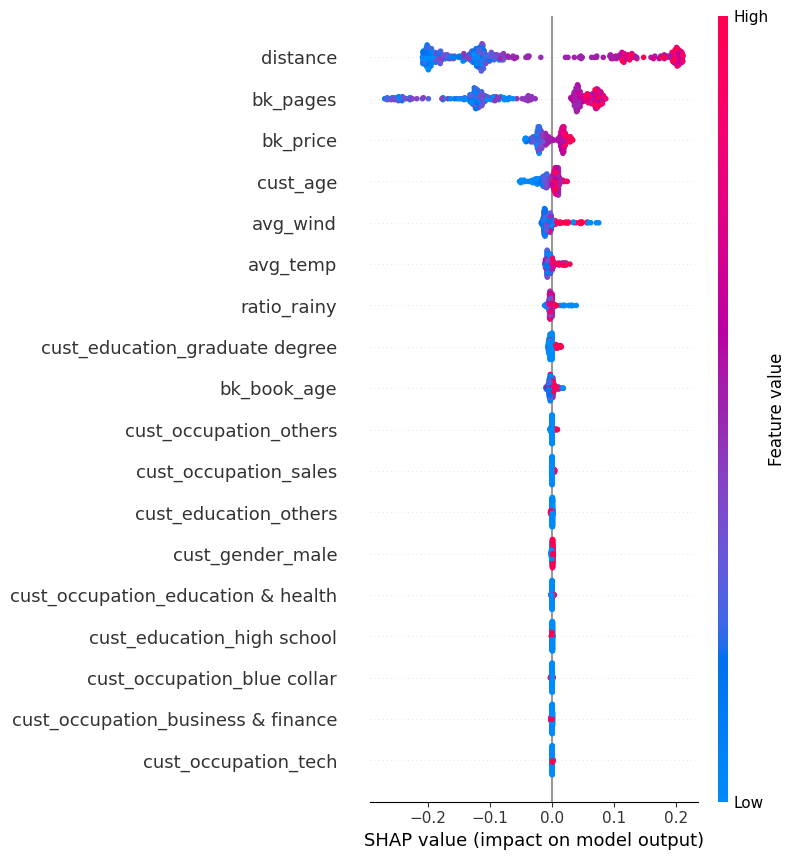

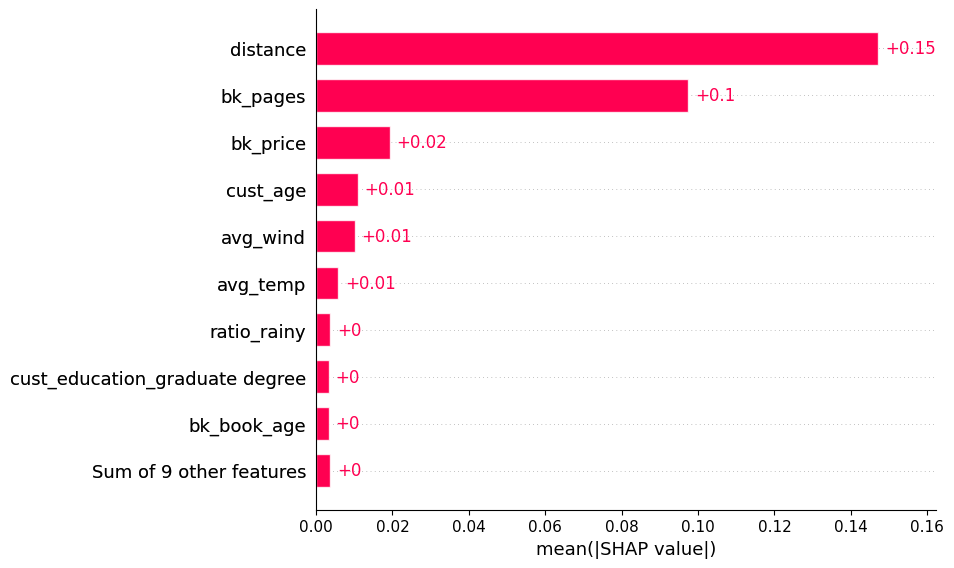

In [55]:
# SHAP values
explainer = shap.TreeExplainer(xgb_grid.best_estimator_)
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values, X_train)
shap.plots.bar(explainer(X_train))


## Test validation

In [56]:
def classification_metrics(y_true, y_pred):
    """
    Compute accuracy, precision, recall, and F1 score.

    Parameters:
        y_true: array-like of shape (n_samples,) — ground truth labels
        y_pred: array-like of shape (n_samples,) — predicted labels

    Returns:
        dict with metrics
    """
    return {
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred, zero_division=0),
        'recall': recall_score(y_true, y_pred,  zero_division=0),
        'f1': f1_score(y_true, y_pred, zero_division=0)
    }

In [57]:
# Random forest performance
classification_metrics(y_test, rf_grid.best_estimator_.predict(X_test))

{'accuracy': 0.9022556390977443,
 'precision': 0.7435897435897436,
 'recall': 0.90625,
 'f1': 0.8169014084507042}

In [58]:
# XGB performance [BEST MODEL on test]
classification_metrics(y_test, xgb_grid.best_estimator_.predict(X_test))

{'accuracy': 0.9473684210526315,
 'precision': 0.8571428571428571,
 'recall': 0.9375,
 'f1': 0.8955223880597015}

In [59]:
# Logistic regression perofrmance
classification_metrics(y_test, log_grid_poly.best_estimator_.predict(X_test))

{'accuracy': 0.8120300751879699,
 'precision': 0.574468085106383,
 'recall': 0.84375,
 'f1': 0.6835443037974683}

### [OPTIONAL] Model Calibration
If probability calibration is needed for XGBoost or Random Forest models, it can be performed as follows.
Calibration is typically required when we want the predicted probabilities to represent true likelihoods—for example, in applications where decision thresholds depend on accurate risk estimates.

Calibration is not needed for logistic regression as this model is well calibrated by nature.

In [60]:
# XGBoost callibration example
# Observation - model calibration in this case comes at the price of lowerin precission and recall.

from sklearn.calibration import CalibratedClassifierCV

best_model =xgb_grid.best_estimator_
calibrated = CalibratedClassifierCV(best_model, method='sigmoid', cv=5)
calibrated.fit(X_train, y_train)

# Predict probabilities
classification_metrics(y_test, calibrated.predict(X_test))

{'accuracy': 0.9398496240601504,
 'precision': 0.8529411764705882,
 'recall': 0.90625,
 'f1': 0.8787878787878788}

# Conclusions and answers

**Model performance** – XGBoost and Random Forest show strong performance on the test set in terms of precision and recall, allowing librarians to accurately estimate whether a customer is likely to return a book on time or not.

**Best model** – XGBoost, test performance:
- `accuracy`: 0.9473684210526315,
- `precision`: 0.8571428571428571,
- `recall`: 0.9375,
- `f1`: 0.8955223880597015

However, this result should be taken with a grain of salt since cross validation results are precission = 0.891794 and recall = 0.751578.
Therefore, we could use these more 'conservative' values.
  
**Main factors associated with late returns** are customer-to-library distance and book length.  
- Customers who live farther from the library are more likely to return books late.  
- Longer books are returned late more frequently compared to shorter ones.

### How to mitigate risks:

**For book length:**
- Adjust loan duration based on book length (e.g., auto-extend for longer books).
- Allow users to request an extension easily via the app or email.

**For distance:**
- Check whether this is the nearest library in library franchise to the customer's address. If not, suggest switching to that location.
- Implement reminders for such users.

### Make library staff buy in

**Financial incentives:**  
Gather data on the time and money costs associated with late returns. Estimate the amount of time and money that could be saved if late returns are prevented or accounted for in advance.

**We identified some of the key factors behind late book returns:**  
- Distance  
- Book length

**Model performance:**  
- When the model predicts a book will be returned late, it's correct about 89% of the time (precision).  
- Out of all actual late returns, the model correctly identifies about 75% of them (recall).


# Improvement Ideas

- Collect additional data to improve model robustness and generalizability.
- Expand geographic data collection — for example, scrape library working hours, working days, and other relevant operational details.
- Test results show partial inconsistency due to randomness in majority class subsampling, train/test splitting, and the small number of positive class samples. The process should be improved to stabilize the test set and ensure it is a representative sample of the overall data.
- ...

# Caveats

- The code in this repository represents a quickly written, proof-of-concept (POC)-level implementation intended for initial exploration.